# Chapter 13: Standardization and the parametric g-formula

> In this chapter we describe how to use standardization to estimate the average causal effect of smoking cessation on body weight gain.

- 13.1 Standardization as an alternative to IP weighting
- 13.2 Estimating the mean outcome via modeling
- 13.3 Standardizing the mean outcome to the confounder distribution
- 13.4 IP weighting or standardization?
- 13.5 How seriously do we take our estimates?

## Functions

In [1]:
import pandas as pd
import dask.dataframe as dd

raw_cont_vars = ["age", "wt71", "smokeintensity", "smokeyrs"]
cat_vars = ["sex", "race", "education", "exercise", "active"]

def add_raw_quadratics(df, varnames):
    for var in varnames:
        df[f"{var}_sq"] = df[var] ** 2
    return df

def load_nhefs():
    url = 'https://miguelhernan.org/s/nhefs.csv'
    df = pd.read_csv(url)
#    ddf = dd.read_csv(url)
    
    for var in cat_vars:
        df[var] = df[var].astype('category')
    
    df = add_raw_quadratics(df, raw_cont_vars)

    return df
    return dd.from_pandas(df)

cont_vars = raw_cont_vars + [f"{var}_sq" for var in raw_cont_vars]

## Questions

- Q1: Estimate the counterfactual mean weight gains in treated and untreated as well as the causal effect of smoking cessation on weight gain using outcome regression followed by standardization
- Q2: Obtain standard errors and confidence intervals for the counterfactual means and the average causal treatment effect estimated in Q1 using the emmeans package
- Q3: Obtain standard errors and confidence intervals for the counterfactual means and the average causal treatment effect estimated in Q1 using the bootstrap.
- Q4 Use the bootstrap-$t$ method to obtain more a precise 95% CI.

### Use of Standardization and the Parametric G-Formula

- Q1: Outcome regression + standardization
- Q2: Confidence intervals (via emmeans-style method)
- Q3: Bootstrap percentile intervals
- Q4: Bootstrap-t CI

- In **Q1**, we fit a regression model for the outcome given treatment and confounders on uncensored data, then used it to **predict outcomes under treatment and no treatment** for the full dataset.
- This process is called **standardization** and corresponds to the **parametric g-formula**: estimating counterfactual means by averaging model-predicted outcomes over the observed confounder distribution.
- The chapter headings this aligns with are:
  - **13.2** Estimating the mean outcome via modeling
  - **13.3** Standardizing the mean outcome to the confounder distribution
- The model serves as a parametric approximation of $\mathbb{E}[Y \mid A, L]$, and standardization approximates $\mathbb{E}[Y^{a}] = \sum_{l} \mathbb{E}[Y \mid A = a, L = l] \cdot P(L = l)$.

In summary, **Q1–Q4 are applications of the parametric g-formula via standardization** to estimate and infer causal effects.

### Q1️⃣: Estimate the counterfactual mean weight gains in treated and untreated as well as the causal effect of smoking cessation on weight gain using outcome regression followed by standardization

- **a.** Fit the linear regression model to data for the uncensored individuals.
- **b.** Estimate the counterfactual mean weight gain in the treated  
  $E[Y^{a=1}, C=0] = 5.18$  
  by predicting from the model on a dataset that includes all uncensored and censored subjects and where the treatment variable is set to “treated” for all subjects.  
  Repeat this for the “untreated” to estimate  
  $E[Y^{a=0}, C=0] = 1.66$.
- **c.** Estimate the average causal treatment effect in the population as the additive contrast of the counterfactual treatment means:  
  $E[Y^{a=1}, C=0] - E[Y^{a=0}, C=0] = 3.52$

In [2]:
import statsmodels.formula.api as smf

df = load_nhefs()
df_unc = df[df["wt82"].notna()]

rhs = (
    "qsmk + " +
    " + ".join(cont_vars) + " + " +
    " + ".join(cat_vars) + " + " +
    "smokeintensity:qsmk"  # patsy syntax
)
formula = f"wt82_71 ~ {rhs}"
model = smf.ols(formula, data=df_unc).fit()

mean_treated = model.predict(df.assign(qsmk=1)).mean()
mean_untreated = model.predict(df.assign(qsmk=0)).mean()
causal_effect = mean_treated - mean_untreated

print(f"E(Ya=1): {mean_treated:.2f}")
print(f"E(Ya=0): {mean_untreated:.2f}")
print(f"Average causal effect: {causal_effect:.2f}")

E(Ya=1): 5.18
E(Ya=0): 1.66
Average causal effect: 3.52


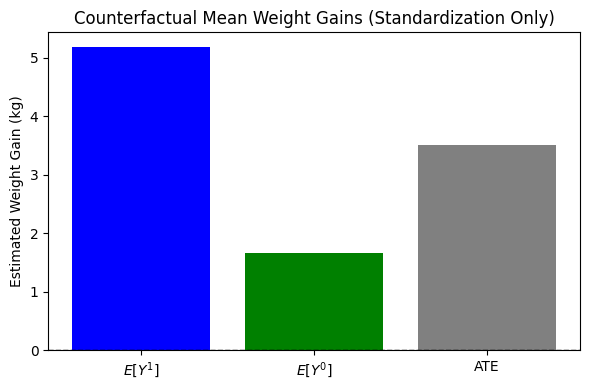

In [3]:
import matplotlib.pyplot as plt

params = ["$E[Y^1]$", "$E[Y^0]$", "ATE"]
values = [mean_treated, mean_untreated, causal_effect]

plt.figure(figsize=(6, 4))
plt.bar(params, values, color=["blue", "green", "gray"])
plt.ylabel("Estimated Weight Gain (kg)")
plt.title("Counterfactual Mean Weight Gains (Standardization Only)")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

### Q2️⃣: Obtain standard errors and confidence intervals for the counterfactual means and the average causal treatment effect estimated in Q1 using the `emmeans` package

**a** - Use the function:
```r
emmeans(fm, "f_qsmk", counterfactuals = "f_qsmk", data = XXXX, vcov. = sandwich::vcovHC(fm, type = "HC0"))
```
where `fm` is a fitted model object to estimate standard errors and confidence intervals for the counterfactual means. Note that the arguments `data` and `vcov.` are optional. Choose an appropriate dataset defining the confounder distribution on which to standardize.

---

**b** - Explain which counterfactual means are estimated in terms of:

  - $E[Y^{a=1}, C=0]$
  - $E[Y^{a=0}, C=0]$

That is, the expected outcomes under treatment ($a=1$) and no treatment ($a=0$), standardized to the observed covariate distribution among uncensored individuals ($C=0$).

#### Q2a: Solution using statsmodels.formula.api and patsy.build_design_matrices

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import patsy
import scipy

cov_type = "HC0"  # White’s original sandwich; nonrobust by default
alpha = 0.05

# Helper: counterfactual mean + robust SE (HC0)
def counterfactual_mean(model, data, qsmk_level):
    """
    Return (estimate, SE) of the counterfactual mean outcome
    if everyone had qsmk = qsmk_level, using HC0 variance.
    """
    design_info = model.model.data.design_info

    repl = pd.Categorical([qsmk_level] * len(data), categories=[0, 1])
    X = patsy.build_design_matrices([design_info], data.assign(qsmk=repl))[0]
    X = np.asarray(X)

    mean_row = X.mean(0)
    beta = model.params
    vcov = model.cov_params()

    est = float(mean_row @ beta)
    se = float(np.sqrt(mean_row @ vcov @ mean_row))
    return est, se


# 1. Load data + fit model with robust HC0 vcov
nhefs = load_nhefs()
nhefs["qsmk"] = nhefs["qsmk"].astype("category")
uncensored = nhefs[nhefs["wt82_71"].notna()]      # C = 0

model = smf.ols(formula, data=uncensored).fit(cov_type=cov_type)

# 2. Counterfactual means and average treatment effect
mean_y0, se_y0 = counterfactual_mean(model, nhefs, 0)
mean_y1, se_y1 = counterfactual_mean(model, nhefs, 1)

ate = mean_y1 - mean_y0
se_ate = np.sqrt(se_y0**2 + se_y1**2)  # assumes independence
crit_t = scipy.stats.t.ppf(1 - alpha / 2, model.df_resid)

# 3. Display
df_q2 = pd.DataFrame({
    "param": ["E_Y0", "E_Y1", "ATE"],
    "est":   [mean_y0, mean_y1, ate],
    "se":    [se_y0, se_y1, se_ate],
    "ci_low": [mean_y0 - crit_t * se_y0,
               mean_y1 - crit_t * se_y1,
               ate      - crit_t * se_ate],
    "ci_upp": [mean_y0 + crit_t * se_y0,
               mean_y1 + crit_t * se_y1,
               ate      + crit_t * se_ate],
})
df_q2

,param,est,se,ci_low,ci_upp
0,E_Y0,1.660267,0.206658,1.254908,2.065626
1,E_Y1,5.178841,0.428710,4.337927,6.019755
2,ATE,3.518574,0.475919,2.585058,4.452090


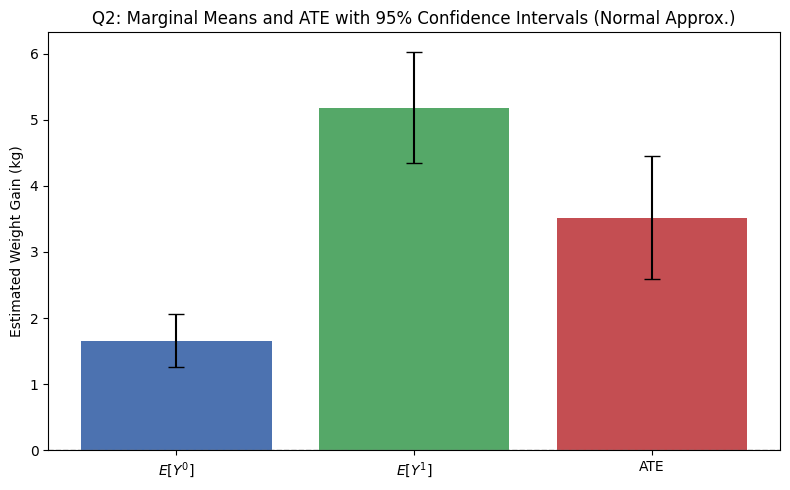

In [5]:
import matplotlib.pyplot as plt

# Estimates and intervals
labels = ["$E[Y^0]$", "$E[Y^1]$", "ATE"]
means = [mean_y0, mean_y1, ate]
lower_bounds = [mean_y0 - crit_t * se_y0, mean_y1 - crit_t * se_y1, ate - crit_t * se_ate]
upper_bounds = [mean_y0 + crit_t * se_y0, mean_y1 + crit_t * se_y1, ate + crit_t * se_ate]
errors = [
    [mean - low for mean, low in zip(means, lower_bounds)],
    [up - mean for mean, up in zip(means, upper_bounds)]
]

# Plot
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(x, means, yerr=errors, capsize=6, color=["#4c72b0", "#55a868", "#c44e52"])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Estimated Weight Gain (kg)")
ax.set_title("Q2: Marginal Means and ATE with 95% Confidence Intervals (Normal Approx.)")
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

#### Q2b: Interpretation of Estimated Counterfactual Means

We estimate:

- $E[Y^{a=1}, C=0]$: expected weight gain **if all had quit smoking**
- $E[Y^{a=0}, C=0]$: expected weight gain **if none had quit**

Both are standardized to the **covariate distribution of uncensored individuals** ($C=0$).

Their difference, the **ATE**, estimates the **causal effect** of quitting smoking, assuming no unmeasured confounding and correct model.

### Q3️⃣: Obtain standard errors and confidence intervals for the counterfactual means and the average causal treatment effect estimated in Q1 using the bootstrap

- Resample the rows of the dataset (**which dataset?**) with replacement and fit the linear regression model to obtain estimates of the counterfactual means and the average causal effect.
- Use $B = 1000$ bootstrap replicates (or as many as your programming skills and patience allow).
- Estimate the standard errors of the three counterfactual parameters:
  - $E[Y^{a=1}, C=0]$
  - $E[Y^{a=0}, C=0]$
  - $E[Y^{a=1}, C=0] - E[Y^{a=0}, C=0]$
- Compute 95% confidence intervals and present the results in a small table.
- Compare the bootstrap results to those obtained from the `emmeans` package in the previous question. For this comparison, use:
  1. The “HC0”-type robust standard errors
  2. The default “HC3”-type robust standard errors  
     (`vcov. = sandwich::vcovHC(fm, type = "HC3")` or simply `vcov. = sandwich::vcovHC`)
  3. The unadjusted standard errors obtained by omitting the `vcov.` argument

- **Question**: Which type of unadjusted or robust standard errors is preferable if you don’t want to go all the way to bootstrap standard errors?


In [36]:
# 1 min 14 sec

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from patsy import build_design_matrices
from scipy.stats import norm
from tqdm import trange
import matplotlib.pyplot as plt

# Settings
np.random.seed(42)
nboot = 1000
alpha = 0.05

# Bootstrap estimates
def bootstrap_estimates(data, formula):
    model = smf.ols(formula, data=data).fit()
    design_info = model.model.data.design_info
    est = []
    for a in [0, 1]:
        repl = pd.Categorical([a] * len(nhefs), categories=[0, 1])
        X = build_design_matrices([design_info], nhefs.assign(qsmk=repl))[0]
        pred = np.asarray(X) @ model.params
        est.append(pred.mean())
    est.append(est[1] - est[0])
    return est

# Run bootstrap
boot_array = np.array([
    bootstrap_estimates(
        uncensored.sample(n=len(uncensored), replace=True),
        formula,
    )
    for _ in trange(nboot)
])

# Wrap in DataFrame
boot3 = pd.DataFrame(boot_array, columns=["E_Y0", "E_Y1", "ATE"])

# Summary table
est = boot3.mean()
sd = boot3.std(ddof=1)
ci_low = est - norm.ppf(1 - alpha / 2) * sd
ci_upp = est + norm.ppf(1 - alpha / 2) * sd
df_q3 = pd.DataFrame({
    "param": ["E_Y0", "E_Y1", "ATE"],
    "est": est.values,
    "se": sd.values,
    "ci_low": ci_low.values,
    "ci_upp": ci_upp.values,
})
df_q3

100%|██████████| 1000/1000 [00:38<00:00, 25.91it/s]


,param,est,se,ci_low,ci_upp
0,E_Y0,1.661615,0.206459,1.256962,2.066267
1,E_Y1,5.173656,0.432943,4.325103,6.022210
2,ATE,3.512042,0.479595,2.572054,4.452030


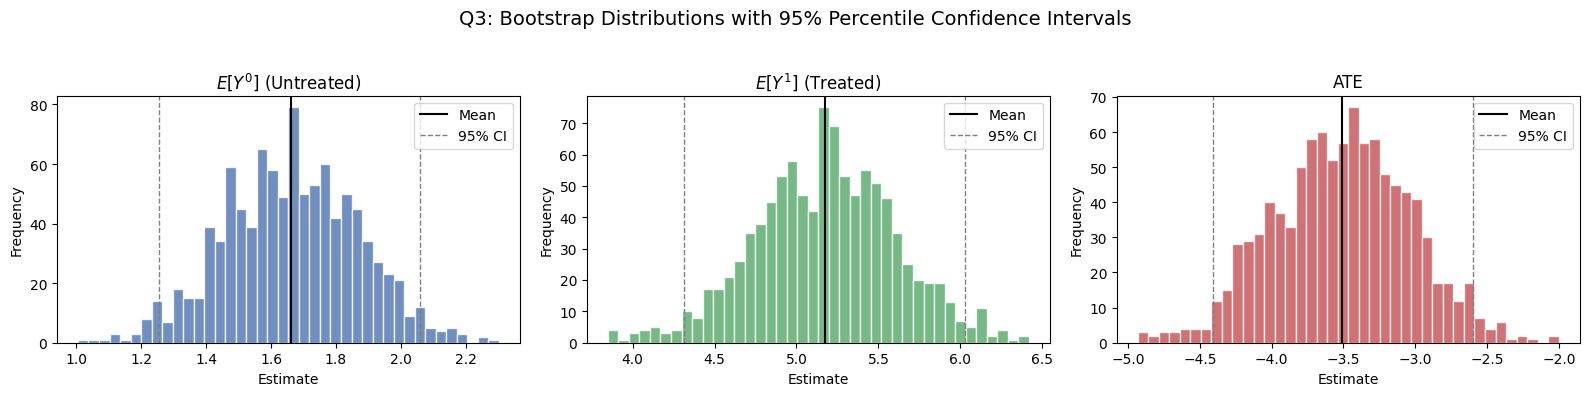

In [7]:
params = ["E_Y0", "E_Y1", "ATE"]
titles = ["$E[Y^0]$ (Untreated)", "$E[Y^1]$ (Treated)", "ATE"]
colors = ["#4c72b0", "#55a868", "#c44e52"]

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=False)

for i, param in enumerate(params):
    ax = axes[i]
    samples = boot3[param]
    mean_val = samples.mean()
    lower, upper = samples.quantile([0.025, 0.975])

    ax.hist(samples, bins=40, color=colors[i], edgecolor='white', alpha=0.8)
    ax.axvline(mean_val, color='black', linestyle='-', linewidth=1.5, label='Mean')
    ax.axvline(lower, color='gray', linestyle='--', linewidth=1, label='95% CI')
    ax.axvline(upper, color='gray', linestyle='--', linewidth=1)
    ax.set_title(titles[i])
    ax.set_xlabel("Estimate")
    ax.set_ylabel("Frequency")
    ax.legend()

fig.suptitle("Q3: Bootstrap Distributions with 95% Percentile Confidence Intervals", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

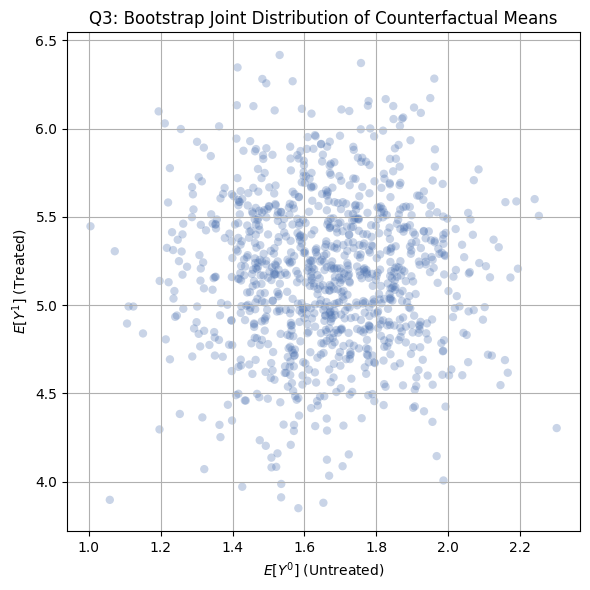

In [8]:
# Scatter plot of bootstrap predictions
plt.figure(figsize=(6, 6))
plt.scatter(boot3["E_Y0"], boot3["E_Y1"], alpha=0.3, edgecolor='none', color="#4c72b0")

plt.xlabel("$E[Y^0]$ (Untreated)")
plt.ylabel("$E[Y^1]$ (Treated)")
plt.title("Q3: Bootstrap Joint Distribution of Counterfactual Means")
plt.grid(True)
plt.tight_layout()
plt.show()

### Q4️⃣: Use the bootstrap-*t* method (cf. <a href="https://pubmed.ncbi.nlm.nih.gov/27019512/">Hesterberg 2014</a>) to obtain a more precise 95% CI

I have discussed the bootstrap-*t* method with most (though not all) of you. If you feel up for the challenge, try the bootstrap-*t* method (cf. <a href="https://arxiv.org/abs/1411.5279?utm_source=chatgpt.com">Hesterberg 2014</a>) to obtain even more accurate 95% confidence intervals for the parameters.

The bootstrap-*t* method improves confidence interval accuracy by accounting for variability in both the estimates and their standard errors.

For each bootstrap sample, compute:

$$
t_b = \frac{\hat\theta_b - \hat\theta}{\text{SE}_b}
$$

Then use the empirical quantiles of the $t_b$ distribution to construct the confidence interval:

$$
\hat\theta \pm t^* \cdot \text{SE}_{\hat\theta}
$$

This method typically yields more accurate 95% confidence intervals than the percentile method, especially in small samples or when the estimator is skewed or heteroskedastic.

| Method        | How It Works                                                            | Assumes Constant SE? | Symmetric? | Accuracy (Small $n$) |
| ------------- | ----------------------------------------------------------------------- | -------------------- | ---------- | ---------------------- |
| Percentile    | Uses percentiles of $\hat\theta_b$                                   | ✅ Yes                | ❌ Maybe    | ❌ Less reliable        |
| Bootstrap-*t* | Uses percentiles of $t_b = \frac{\hat\theta_b - \hat\theta}{SE_b}$ | ❌ No                 | ✅ Better   | ✅ More robust          |


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from patsy import build_design_matrices
from tqdm import trange

# 1) settings & original fit
nboot = 1000
alpha = 0.05
cov_type = "HC0"              # White’s HC0

# assume nhefs, uncensored, and formula are already defined
model = smf.ols(formula, data=uncensored).fit(cov_type=cov_type)
design = model.model.data.design_info
Vb = model.cov_params()
beta = model.params

def cf_mean(a, data):
    """Counterfactual mean on *data* if everyone had qsmk == a."""
    repl = pd.Categorical([a]*len(data), categories=[0,1])
    X = build_design_matrices([design], data.assign(qsmk=repl))[0]
    return (np.asarray(X) @ beta).mean()

# original counterfactual means and robust SEs (match R emmeans)
est0 = cf_mean(0, nhefs)
est1 = cf_mean(1, nhefs)
mean_X0 = build_design_matrices([design], nhefs.assign(qsmk=0))[0].mean(0)
mean_X1 = build_design_matrices([design], nhefs.assign(qsmk=1))[0].mean(0)
se0 = np.sqrt(mean_X0 @ Vb @ mean_X0)
se1 = np.sqrt(mean_X1 @ Vb @ mean_X1)
est = np.array([est0, est1, est1-est0])
se = np.array([se0, se1, np.sqrt(se0**2 + se1**2)])

# 2) bootstrap-t loop
t_star = []
for _ in trange(nboot, desc="bootstrap-t"):
    dboot = nhefs.sample(len(nhefs), replace=True)      # resample rows
    mb0 = cf_mean(0, dboot)                           # only means vary
    mb1 = cf_mean(1, dboot)
    mu_b = np.array([mb0, mb1, mb1-mb0])

    # SEs are *fixed*
    t_star.append((mu_b - est) / se)

t_star = np.array(t_star)                               # shape (B, 3)

# R quantile type 6 equivalent to numpy method="inverted_cdf"
q_lo = np.quantile(t_star, alpha/2 , axis=None, method="inverted_cdf")
q_hi = np.quantile(t_star, 1-alpha/2, axis=None, method="inverted_cdf")

ci_low = est - q_hi * se
ci_upp = est - q_lo * se

df_q4 = pd.DataFrame({
    "param": ["E_Y0", "E_Y1", "ATE"],
    "est": est,
    "sd_boot": se,
    "se": se,
    "q1": q_lo,
    "q2": q_hi,
    "ci_low": ci_low,
    "ci_upp": ci_upp,
})
df_q4


bootstrap-t: 100%|██████████| 1000/1000 [00:23<00:00, 43.06it/s]


,param,est,se,q1,q2,ci_low,ci_upp
0,E_Y0,1.660267,0.206658,-0.473626,0.495015,1.557968,1.758145
1,E_Y1,5.178841,0.428710,-0.473626,0.495015,4.966624,5.381889
2,ATE,3.518574,0.475919,-0.473626,0.495015,3.282987,3.743982


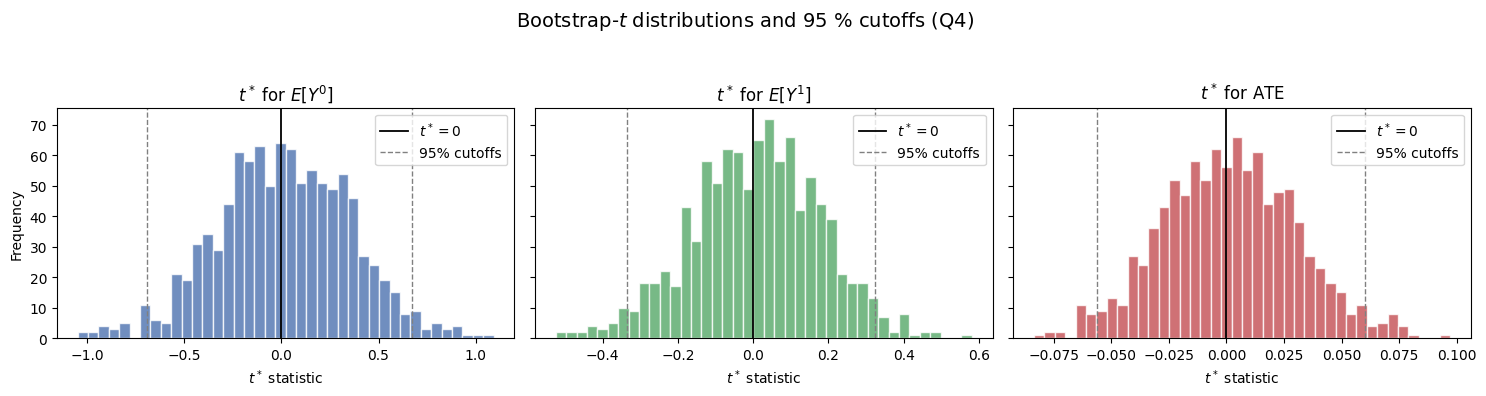

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# t_star has shape (nboot, 3) → columns: Y0, Y1, ATE
titles = [r"$t^*$ for $E[Y^{0}]$",     # treated as Y0
          r"$t^*$ for $E[Y^{1}]$",     # treated as Y1
          r"$t^*$ for ATE"]
colors = ["#4c72b0", "#55a868", "#c44e52"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for idx in range(3):
    ax = axes[idx]
    vals = t_star[:, idx]
    lower, upper = np.quantile(vals, [alpha / 2, 1 - alpha / 2],
                               method="inverted_cdf")

    ax.hist(vals, bins=40, color=colors[idx], edgecolor="white", alpha=0.8)
    ax.axvline(0, color="black", linestyle="-", linewidth=1.3, label="$t^*=0$")
    ax.axvline(lower, color="gray", linestyle="--", linewidth=1.0, label="95% cutoffs")
    ax.axvline(upper, color="gray", linestyle="--", linewidth=1.0)
    ax.set_title(titles[idx])
    ax.set_xlabel("$t^*$ statistic")
    if idx == 0:
        ax.set_ylabel("Frequency")
    ax.legend()

fig.suptitle("Bootstrap-$t$ distributions and 95 % cutoffs (Q4)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


## Comparison of Q2-Q4

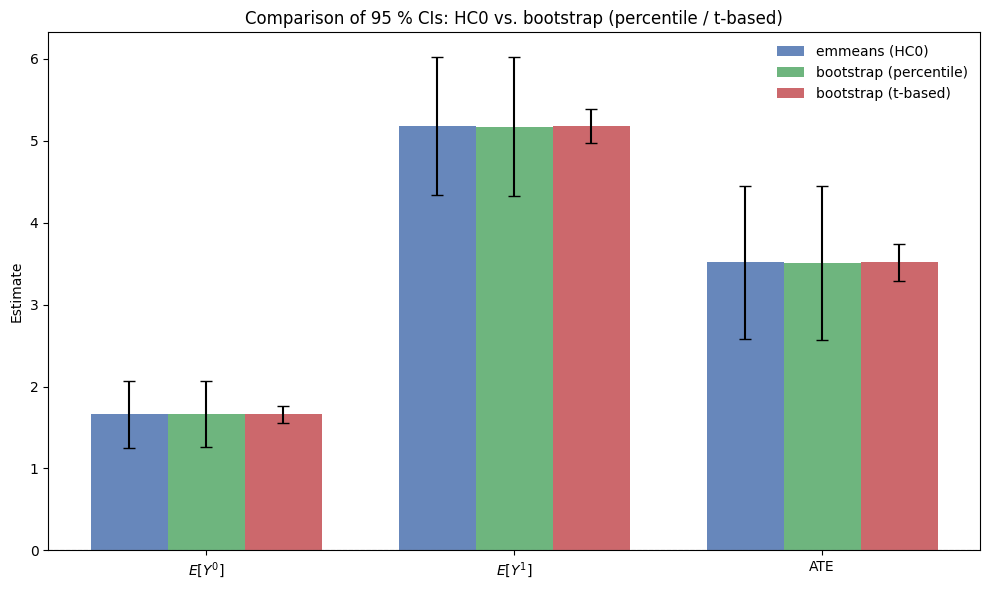

In [53]:
df_q2["method"] = "emmeans (HC0)"
df_q3["method"] = "bootstrap (percentile)"
df_q4["method"] = "bootstrap (t-based)"

# 1) Combine and order
param_order = ["E_Y0", "E_Y1", "ATE"]        # one consistent spelling
cis = pd.concat([df_q2, df_q3, df_q4], ignore_index=True)

cis["param"] = pd.Categorical(cis["param"], categories=param_order, ordered=True)
cis.sort_values(["param", "method"], inplace=True)

# 2) Grouped bar chart
import matplotlib.pyplot as plt
import numpy as np

methods = [df_q2["method"].iloc[0], df_q3["method"].iloc[0], df_q4["method"].iloc[0]]
colors = ["#4c72b0", "#55a868", "#c44e52"]
x = np.arange(len(param_order))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for idx, method in enumerate(methods):
    subset = cis[cis["method"] == method].set_index("param").loc[param_order]
    offset = (idx - (len(methods) - 1) / 2) * width
    est = subset["est"].values
    yerr = np.vstack([est - subset["ci_low"].values,
                      subset["ci_upp"].values - est])
    ax.bar(x + offset, est, width,
           label=method, color=colors[idx], alpha=0.85)
    ax.errorbar(x + offset, est, yerr=yerr,
                fmt="none", ecolor="black", capsize=4)

ax.set_xticks(x)
ax.set_xticklabels([r"$E[Y^{0}]$", r"$E[Y^{1}]$", "ATE"])
ax.set_ylabel("Estimate")
ax.set_title("Comparison of 95 % CIs: HC0 vs. bootstrap (percentile / t-based)")
ax.axhline(0, color="grey", linestyle="--", lw=0.8)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

In [56]:
methods = [df_q2["method"].iloc[0], df_q3["method"].iloc[0], df_q4["method"].iloc[0]]

ci_width = cis.assign(width = cis["ci_upp"] - cis["ci_low"])
table = ci_width.pivot(index="param", columns="method", values="width")

# Reorder columns explicitly
table = table[methods]

print(table.round(3))

method  emmeans (HC0)  bootstrap (percentile)  bootstrap (t-based)
param                                                             
E_Y0            0.811                   0.809                0.200
E_Y1            1.682                   1.697                0.415
ATE             1.867                   1.880                0.461


## QQ plots of ATE for bootstrap methods of Q3 and Q4

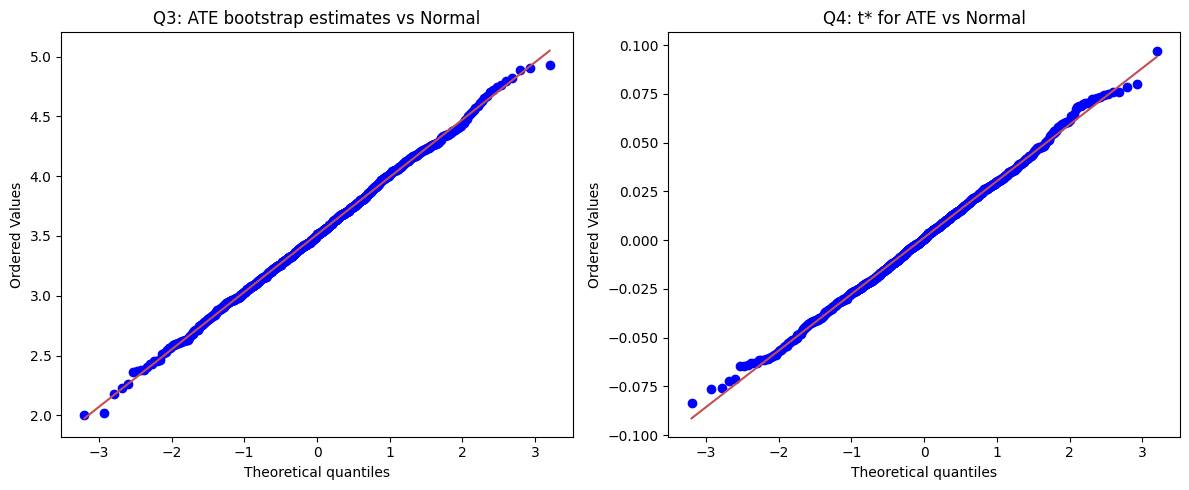

In [59]:
import scipy.stats as stats

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Q3 – percentile bootstrap distribution of ATE
stats.probplot(boot3["ATE"], dist="norm", plot=axes[0])
axes[0].set_title("Q3: ATE bootstrap estimates vs Normal")

# Q4 – bootstrap-t values for ATE
stats.probplot(t_star[:, 2], dist="norm", plot=axes[1])
axes[1].set_title("Q4: t* for ATE vs Normal")

for ax in axes:
    ax.get_lines()[1].set_color("#c44e52")   # make the fit line visible

plt.tight_layout()
plt.show()